In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xobjects as xo
import xtrack as xt
import xpart as xp

ctx = xo.ContextCpu()  # Use xo.ContextCupy() for GPU

In [2]:
# Physical constants
c   = 299792458  # speed of light in m/s
c2  = c*c
e   = 1.602176634e-19  # elementary charge in C
m_e = 9.1093837015e-31  # electron/positron mass in kg
m_p = 1.67262192e-27 # proton/antiproton mass in kg


u = {
    'c': 299792458,
    'c2': 299792458**2,
    'rest_e': xt.ELECTRON_MASS_EV,
    'rest_p': xt.PROTON_MASS_EV,
    'm_to_cm': 1e2,
    'm_to_mm': 1e3,
    'm_to_um': 1e6,
    'cm_to_mm': 1e1,
    'cm_to_um': 1e4,
    'cm_to_m': 1e-2,
    'mm_to_m': 1e-3,
    'mm_to_cm': 1e-1,
    'mm_to_um': 1e3,
    'um_to_mm': 1e-3,
    'um_to_cm': 1e-4,
    'um_to_m': 1e-6,
    'kG_to_T': 0.1,
    'GeV_to_kgms': 5.39e-19,
    'GeV_to_kg': 1.8e-27,
    'GeV_to_kgm2s2': 1.6e-10,
}

def p_from_E(E, E_rest):
    # m is in eV
    # E is in eV
    # p is in eV / c
    pc = (E**2 - (E_rest)**2)**0.5
    return pc / u['c']

ref = {
    'q': 1,
    'p': p_from_E(1e9, u['rest_e']),  # E = 1 MeV
    'betx_0': 1.0,
    'alfx_0': 0.0,
    'bety_0': 1.0,
    'alfy_0': 0.0,
}


def grad_kG_to_k(grad_kG):
    grad_T = grad_kG * u['kG_to_T']
    k = grad_T / ref['p']
    return k

def B_T_to_k(B_T):
    k = B_T / ref['p']
    return k

print(ref['p'])


3.3356405164803316


In [3]:
env = xt.Environment()

env['kq_p'] = grad_kG_to_k(-6.66)
env['kq_n'] = grad_kG_to_k(28.86)
env['kd'] = B_T_to_k(0.219)


env['qL'] = 1

In [4]:
# Creating Line
line = env.new_line(components=[
    env.new('d0', xt.Drift, length=3.6),
    env.new('q0', xt.Quadrupole, length='qL', k1='kq_p'),
    env.new('d0.1', xt.Drift, length=1.3),
    env.new('q1', xt.Quadrupole, length='qL', k1s='kq_n'),
    env.new('d1.2', xt.Drift, length=1.3),
    env.new('q2', xt.Quadrupole, length='qL', k1='kq_p'),
    env.new('d2.2', xt.Drift, length=1.2),
    env.new('dd', xt.Bend, length=0.5, k0='kd'),
])


line.particle_ref = xt.Particles(
    p0c=ref['p'] * u['c'],  # in eV
    mass0=xt.ELECTRON_MASS_EV,
    q0=1,
)

line.build_tracker()


In [5]:
# Twiss
init = xt.TwissInit(betx=ref['betx_0'], alfx=ref['alfx_0'], bety=ref['bety_0'], alfy=ref['alfy_0'])  # example values

tw = line.twiss(
    method='4d',
    init=init,
    end='_end_point',
)


name                   s       sigma_x       sigma_y    sigma_zeta      sigma_px      sigma_py ...
d0                     0   3.57421e-05   3.57421e-05             0   3.57421e-05   3.57421e-05
q0                   3.6   0.000133543   0.000133543             0   3.57421e-05   3.57421e-05
d0.1                 4.6   0.000182962   0.000154014             0   6.63357e-05   1.01103e-05
q1                   5.9   0.000268872   0.000161888             0   6.63357e-05   1.01103e-05
d1.2                 6.9   0.000342598   0.000213121             0   0.000157492   0.000261455
q2                   8.2   0.000493469     0.0005026             0   0.000157492   0.000261455
d2.2                 9.2   0.000684935   0.000697037             0   0.000264296   0.000147604
dd                  10.4   0.000995822   0.000861041             0   0.000264296   0.000147604
_end_point          10.9    0.00112646   0.000930809   2.17079e-06   0.000264296   0.000147604


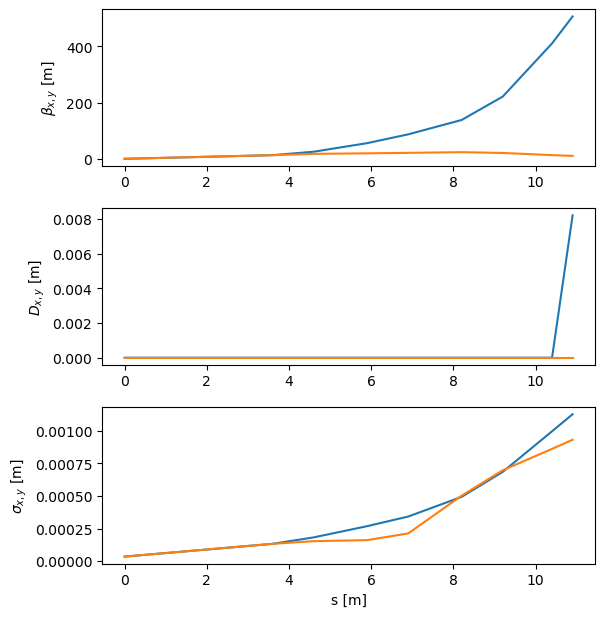

In [6]:
# Beam size investigation

# Transverse normalized emittances
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6

# Longitudinal emittance from energy spread
sigma_pzeta = 2e-4
gemitt_zeta = sigma_pzeta**2 * 1.0
# similarly, if the bunch length is known, the emittance can be computed as
# gemitt_zeta = sigma_zeta**2 / tw.bets0

# Compute beam sizes
beam_sizes = tw.get_beam_covariance(nemitt_x=nemitt_x, nemitt_y=nemitt_y,
                                    gemitt_zeta=gemitt_zeta)

# Inspect beam sizes (table can be accessed similarly to twiss tables)
beam_sizes.show()


# Plot
import matplotlib.pyplot as plt
plt.close('all')

fig1 = plt.figure(1, figsize=(6.4, 4.8*1.5))
spbet = plt.subplot(3,1,1)
spdisp = plt.subplot(3,1,2, sharex=spbet)
spbsz = plt.subplot(3,1,3, sharex=spbet)

spbet.plot(tw.s, tw.betx)
spbet.plot(tw.s, tw.bety)
spbet.set_ylabel(r'$\beta_{x,y}$ [m]')

spdisp.plot(tw.s, tw.dx)
spdisp.plot(tw.s, tw.dy)
spdisp.set_ylabel(r'$D_{x,y}$ [m]')

spbsz.plot(beam_sizes.s, beam_sizes.sigma_x)
spbsz.plot(beam_sizes.s, beam_sizes.sigma_y)
spbsz.set_ylabel(r'$\sigma_{x,y}$ [m]')
spbsz.set_xlabel('s [m]')


fig1.subplots_adjust(left=.15, right=.92, hspace=.27)
plt.show()


In [ ]:
particles = line.build_particles(_context=ctx, x=1e-3, y=-1e-3, px=0, py=0, zeta=0, delta=0)

line.discard_tracker()

# Create monitor elements 
tt = line.get_table()
print(tt)

print("~~~~~~~~~~~~~~~~~~")

s_insert = np.array([])
l_insert = np.array([1.0, 1.0, 1.0])
n = 1
monitor = xt.ParticlesMonitor(num_particles=n, start_at_turn=0, stop_at_turn=1)

ele_insert = [monitor for _ in range(len(s_insert))]


line._insert_thick_elements_at_s(
    element_names=[f'm{i}' for i in range(len(s_insert))],
    elements=ele_insert,
    at_s=s_insert
)
tt = line.get_table()
print(tt.cols['name s element_type'])


line.build_tracker()
line.track(particles)
# Access monitor data
m_data = {}
for element_name in ["m0", "m1", "m2", "md"]:
    m_data[element_name] = line.element_by_name(element_name).data

# Print some monitor data info
for name, data in m_data.items():
    print(f"{name} at s={data.s[0]:.2f}m: x={data.x[0]*1e3:.3f}mm, y={data.y[0]*1e3:.3f}mm")

# Plot the particle trajectory at monitor points
plt.figure(figsize=(10, 4))
s_values = [data.s[0] for data in m_data.values()]
x_values = [data.x[0] for data in m_data.values()]
y_values = [data.y[0] for data in m_data.values()]

plt.plot(s_values, np.array(x_values)*1e3, 'o-', label='x')
plt.plot(s_values, np.array(y_values)*1e3, 'o-', label='y')
plt.xlabel("s [m]")
plt.ylabel("Position [mm]")
plt.legend()
plt.grid(True)
plt.title("Particle trajectory at monitor locations")
plt.figure(figsize=(10, 5))
plt.suptitle("Phase space at z = 0 m")
plt.subplot(1, 2, 1)
plt.plot(particles.x * 1e3, particles.px * 1e3, '.', markersize=1)
plt.xlabel("x [mm]")
plt.ylabel("px [mrad]")
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.plot(particles.y * 1e3, particles.py * 1e3, '.', markersize=1)
plt.xlabel("y [mm]")
plt.ylabel("py [mrad]")
plt.axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


line.track(particles)


Table: 9 rows, 11 cols
name                   s element_type isthick isreplica parent_name iscollective       s_start ...
d0                     0 Drift           True     False None               False             0
q0                   3.6 Quadrupole      True     False None               False           3.6
d0.1                 4.6 Drift           True     False None               False           4.6
q1                   5.9 Quadrupole      True     False None               False           5.9
d1.2                 6.9 Drift           True     False None               False           6.9
q2                   8.2 Quadrupole      True     False None               False           8.2
d2.2                 9.2 Drift           True     False None               False           9.2
dd                  10.4 Bend            True     False None               False          10.4
_end_point          10.9                False     False None               False          10.9
~~~~~~~~~~~~~~~~~~


Slicing line:   0%|          | 0/8 [00:00<?, ?it/s]

Table: 9 rows, 3 cols
name                   s element_type
d0                     0 Drift       
q0                   3.6 Quadrupole  
d0.1                 4.6 Drift       
q1                   5.9 Quadrupole  
d1.2                 6.9 Drift       
q2                   8.2 Quadrupole  
d2.2                 9.2 Drift       
dd                  10.4 Bend        
_end_point          10.9             


AttributeError: 'Line' object has no attribute 'element_by_name'